<a href="https://colab.research.google.com/github/ahmed95mehribanli/Taxi-Price-Regression/blob/main/Taxi_Price_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split


from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import ConfusionMatrixDisplay


In [123]:
#import and review of general data
df1 = pd.read_csv("taxi_trip_pricing.csv")
df1.head(6)

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180
5,8.64,Afternoon,Weekend,2.0,Medium,Clear,2.55,1.71,0.48,89.33,60.2028


In [124]:
df1.tail(6)

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
994,18.69,Evening,Weekday,3.0,Medium,Clear,4.90,1.79,0.17,79.41,51.8548
995,5.49,Afternoon,Weekend,4.0,Medium,Clear,2.39,0.62,0.49,58.39,34.4049
996,45.95,Night,Weekday,4.0,Medium,Clear,3.12,0.61,NaN,61.96,62.1295
997,7.70,Morning,Weekday,3.0,Low,Rain,2.08,1.78,NaN,54.18,33.1236
998,47.56,Morning,Weekday,1.0,Low,Clear,2.67,0.82,0.17,114.94,61.2090
999,22.85,Morning,Weekend,3.0,Medium,Clear,4.34,NaN,0.23,29.69,45.4437


In [125]:
df1.shape

(1000, 11)

In [126]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


In [127]:
# Using value_counts() to get unique values and their counts
for column in df1.columns:
    print(f"Unique values in {column}:")
    print(df1[column].value_counts())
    print()

Unique values in Trip_Distance_km:
Trip_Distance_km
10.14    3
13.64    3
32.04    3
31.29    3
3.22     3
        ..
32.12    1
19.36    1
31.67    1
25.65    1
22.85    1
Name: count, Length: 867, dtype: int64

Unique values in Time_of_Day:
Time_of_Day
Afternoon    371
Morning      283
Evening      203
Night         93
Name: count, dtype: int64

Unique values in Day_of_Week:
Day_of_Week
Weekday    655
Weekend    295
Name: count, dtype: int64

Unique values in Passenger_Count:
Passenger_Count
3.0    251
2.0    241
1.0    238
4.0    220
Name: count, dtype: int64

Unique values in Traffic_Conditions:
Traffic_Conditions
Low       397
Medium    371
High      182
Name: count, dtype: int64

Unique values in Weather:
Weather
Clear    667
Rain     227
Snow      56
Name: count, dtype: int64

Unique values in Base_Fare:
Base_Fare
3.94    10
2.80     8
3.88     8
2.32     8
4.62     7
        ..
3.18     1
4.38     1
2.54     1
3.98     1
2.67     1
Name: count, Length: 290, dtype: int64

Unique

In [128]:
# getting the number of missing values in each column
df1.isnull().sum()

Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Conditions       50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64

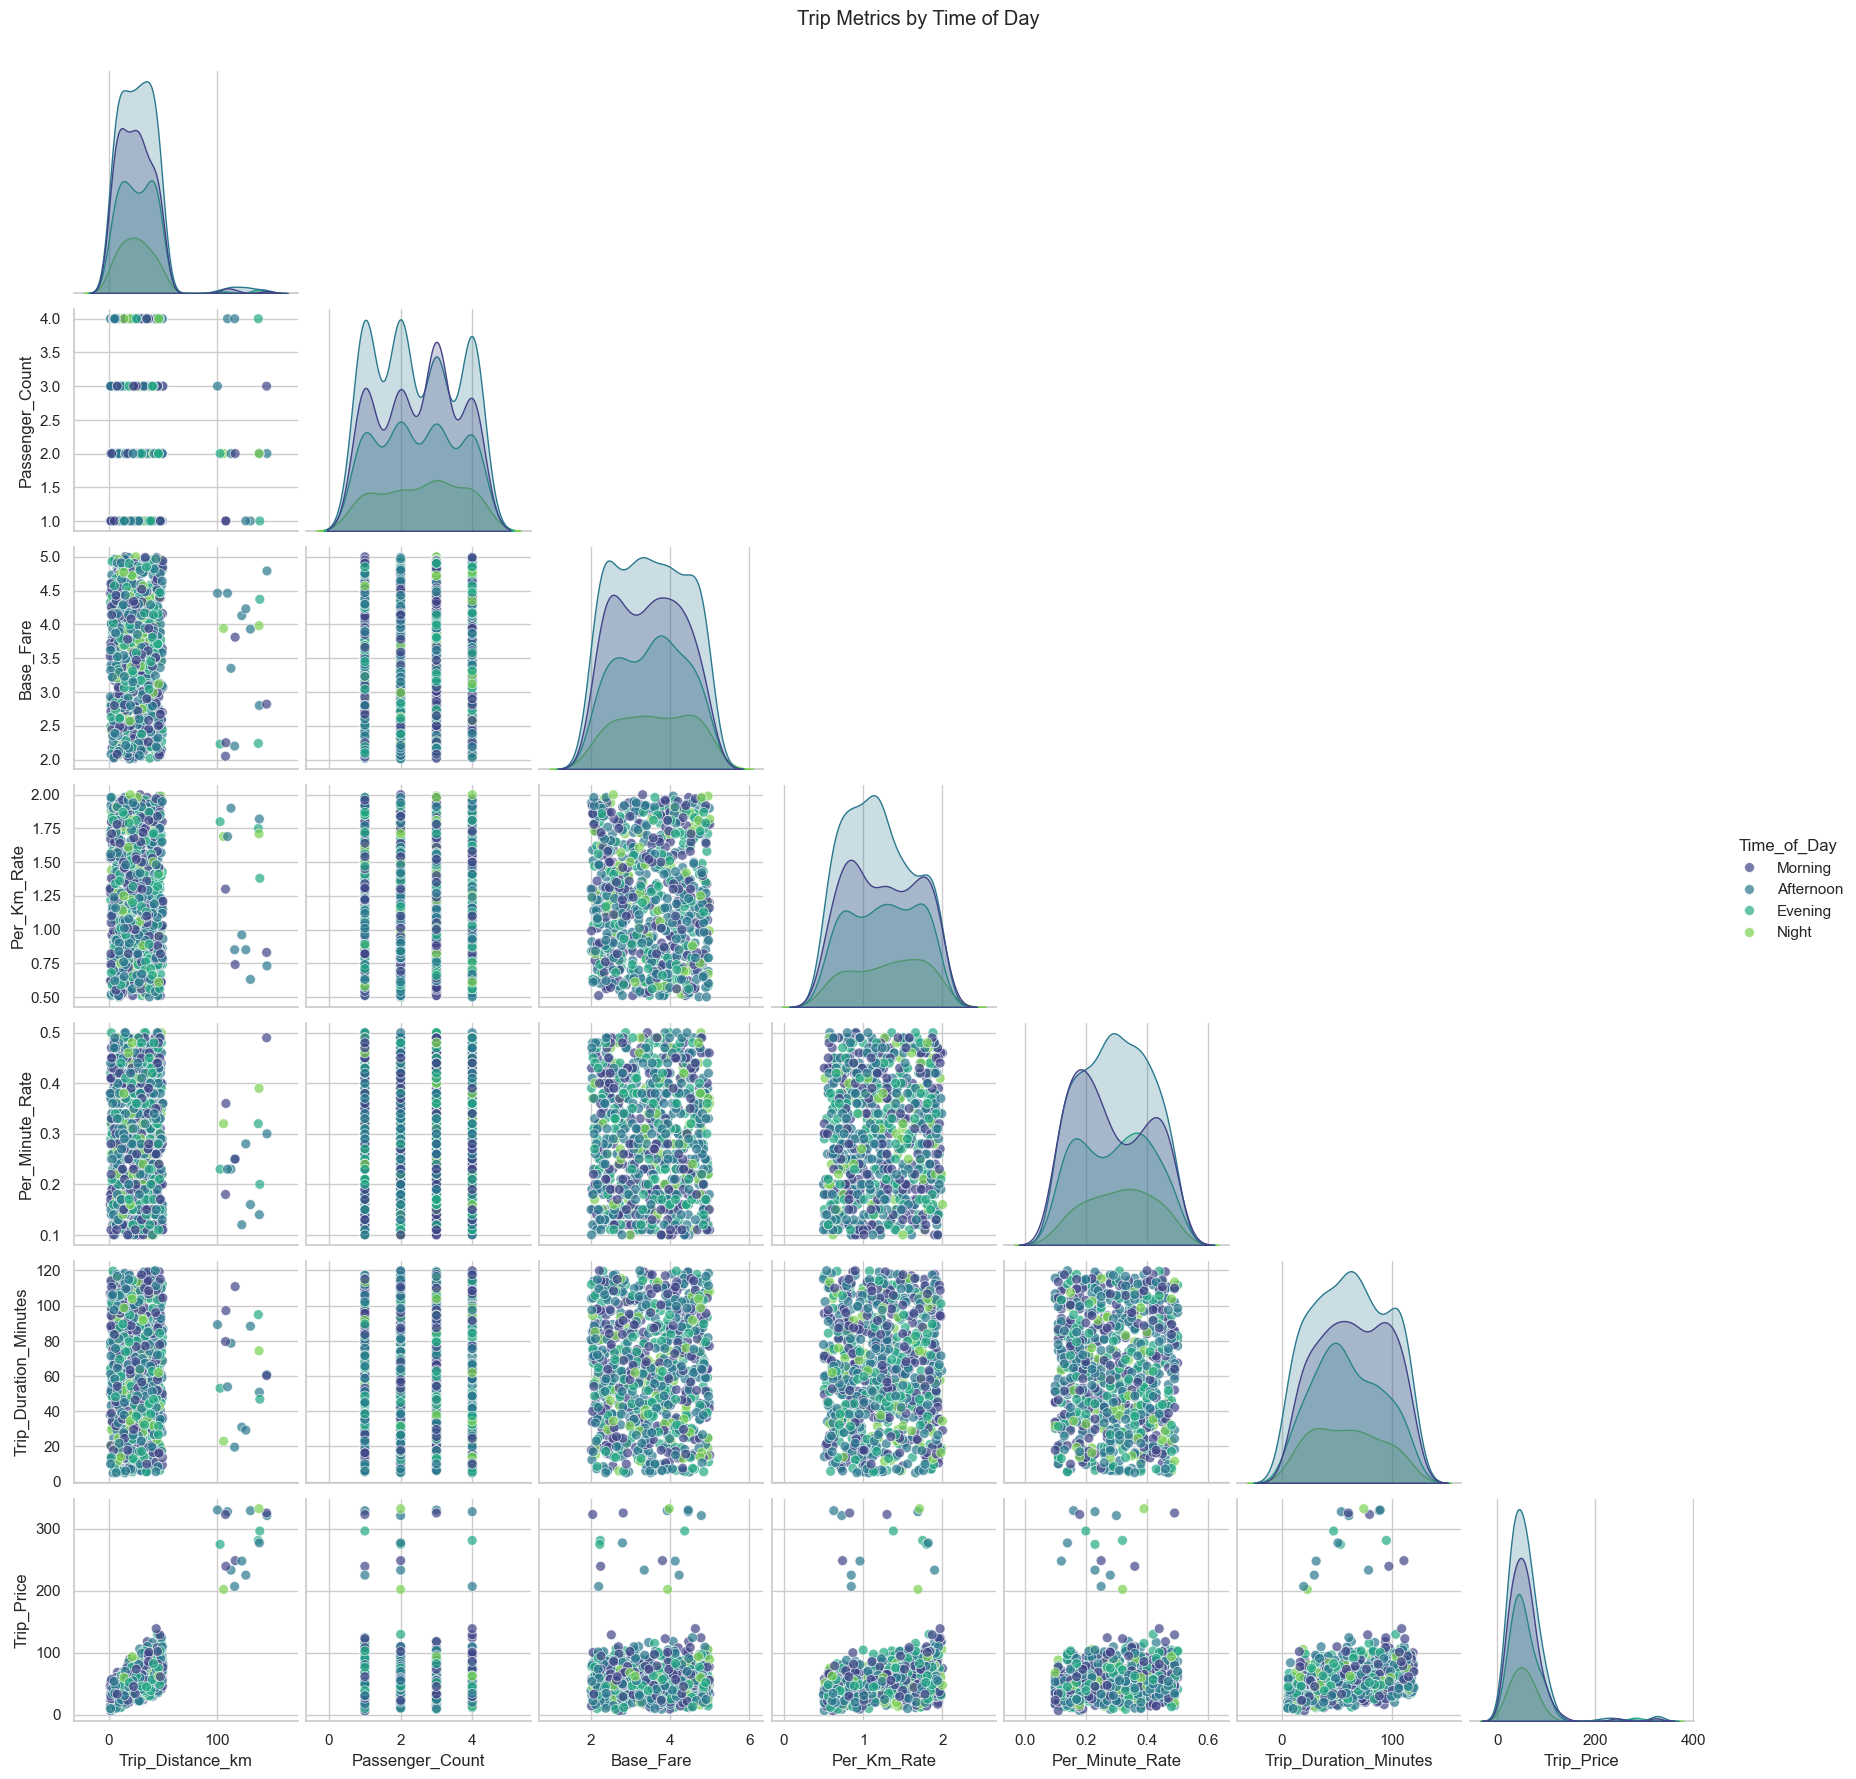

In [129]:
# Auto-select numerical columns (skip categorical)
num_cols = df1.select_dtypes(include=['float64']).columns.tolist()

sns_plot = sns.pairplot(
    df1,
    vars=num_cols,          # Use only numerical columns
    hue='Time_of_Day',      # Color by time (morning/afternoon/night)
    palette='viridis',      # Color scheme
    diag_kind='kde',        # Density plots on diagonal
    plot_kws={'alpha': 0.7, 's': 50},
    corner=True             # Remove redundant upper triangle
)

plt.suptitle("Trip Metrics by Time of Day", y=1.02)
sns_plot.savefig('pairplot_time_of_day.png', dpi=300, bbox_inches='tight')
plt.show()
#Reveals how relationships (e.g., Trip_Distance_km vs. Trip_Price) vary by time of day.
#Avoids clutter by excluding categorical columns from the grid.

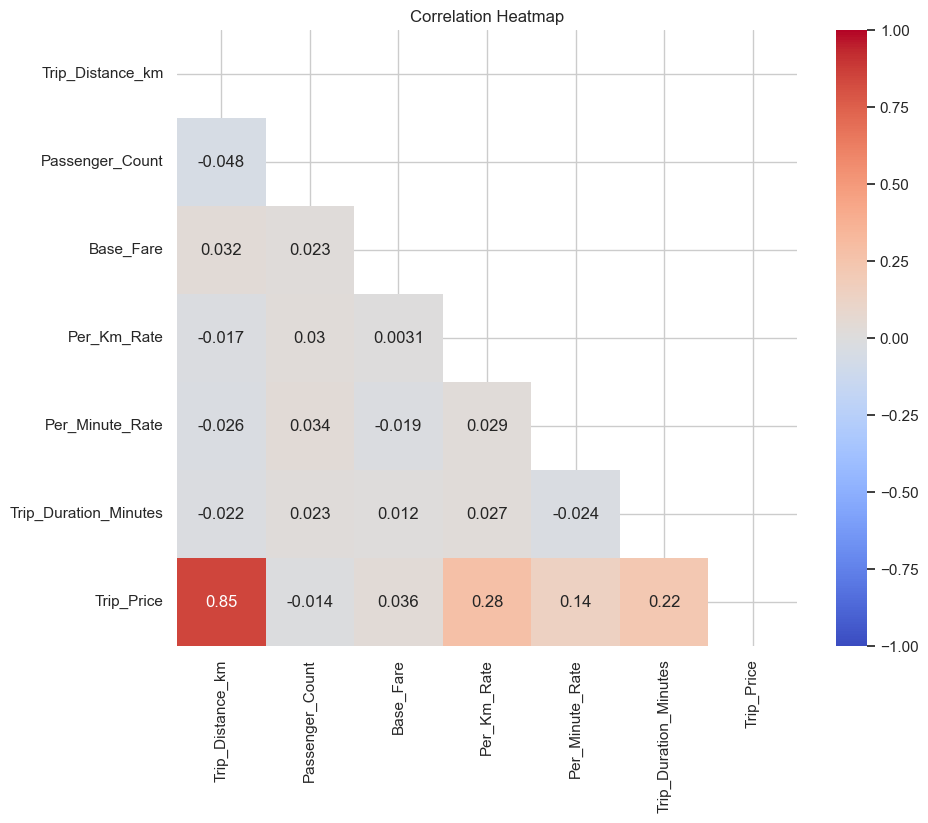

In [130]:
# Calculate correlations
corr = df1[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,      # Show correlation values
    cmap='coolwarm',  # Red (positive) vs. Blue (negative)
    vmin=-1, vmax=1,  # Fix scale from -1 to 1
    mask=np.triu(corr) # Show only lower triangle
)
plt.title("Correlation Heatmap")
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
#Highlights strong correlations (e.g., does Trip_Duration_Minutes affect Trip_Price?).
#Easier to read than scatterplot annotations.

In [131]:
import plotly.express as px

fig = px.scatter_matrix(
    df1,
    dimensions=num_cols,
    color='Weather',           # Color by weather condition
    title="Interactive Trip Metrics Explorer",
    hover_data=['Day_of_Week'] # Add extra info on hover
)
fig.update_traces(
    diagonal_visible=False,    # Hide diagonal plots
    marker={'size': 5, 'opacity': 0.7}
)
fig.show()
fig.write_html("interactive_pairplot.html")
#Explore outliers by hovering (e.g., high-price trips).
#Toggle categories (rain vs. sunny days).

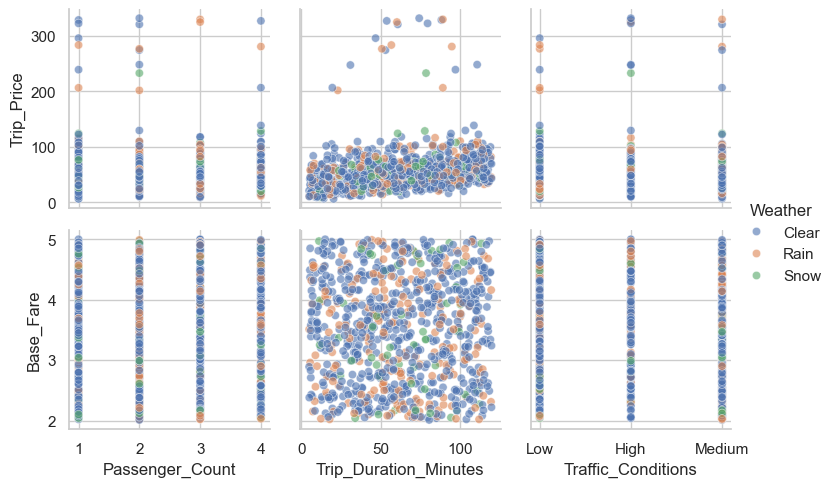

In [132]:
g = sns.PairGrid(
    df1,
    x_vars=['Passenger_Count', 'Trip_Duration_Minutes', 'Traffic_Conditions'],
    y_vars=['Trip_Price', 'Base_Fare'],
    hue='Weather'
)
g.map(sns.scatterplot, alpha=0.6)
g.add_legend()
plt.savefig('targeted_grid.png', dpi=300)
#Avoids overwhelming plots.
#Answers business questions directly.

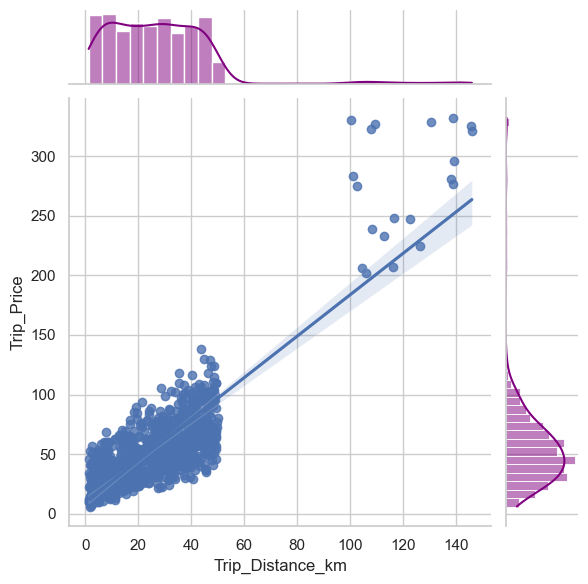

In [133]:
sns.jointplot(
    data=df1,
    x='Trip_Distance_km',
    y='Trip_Price',
    kind='reg',        # Regression line + scatter
    marginal_kws={'color': 'purple'}
)
plt.savefig('distance_vs_price.png', dpi=300)
#Shows trend line and distribution margins.
#Great for presentations.

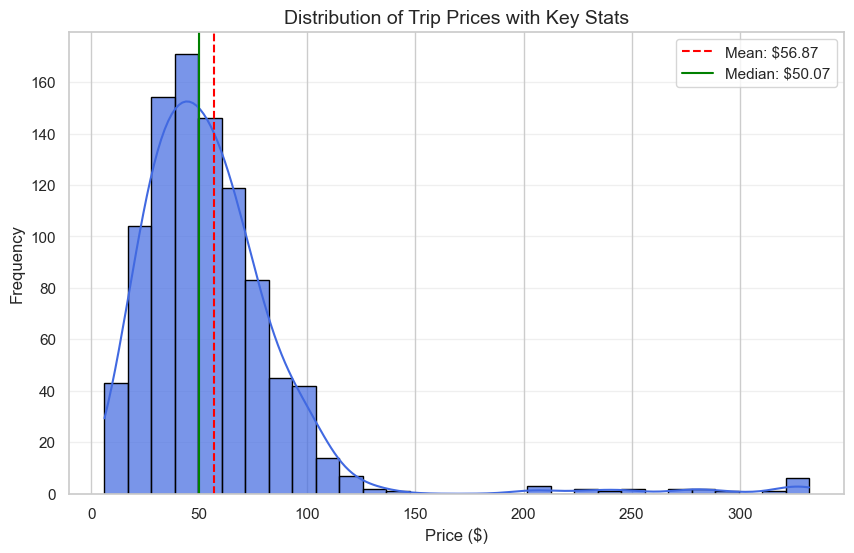

In [134]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(
    df1['Trip_Price'],
    bins=30,                     # Custom bin count
    kde=True,
    color='royalblue',
    edgecolor='black',
    alpha=0.7
)

# Add mean/median lines
plt.axvline(df1['Trip_Price'].mean(), color='red', linestyle='--', label=f'Mean: ${df1["Trip_Price"].mean():.2f}')
plt.axvline(df1['Trip_Price'].median(), color='green', linestyle='-', label=f'Median: ${df1["Trip_Price"].median():.2f}')

plt.title("Distribution of Trip Prices with Key Stats", fontsize=14)
plt.xlabel("Price ($)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()
#Highlights mean vs. median (shows skewness).
#Custom bins improve granularity.

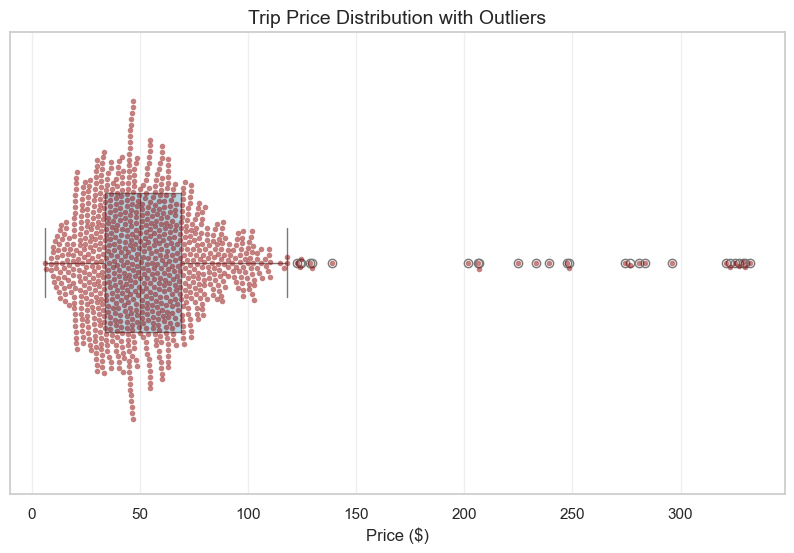

In [135]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x=df1['Trip_Price'],
    color='lightblue',
    width=0.3,
    showfliers=True  # Show outliers
)
sns.swarmplot(
    x=df1['Trip_Price'],
    color='darkred',
    size=4,
    alpha=0.5
)
plt.title("Trip Price Distribution with Outliers", fontsize=14)
plt.xlabel("Price ($)", fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.show()
#Clearly identifies outliers (unusually high/low prices).
#Swarmplot shows actual data density.

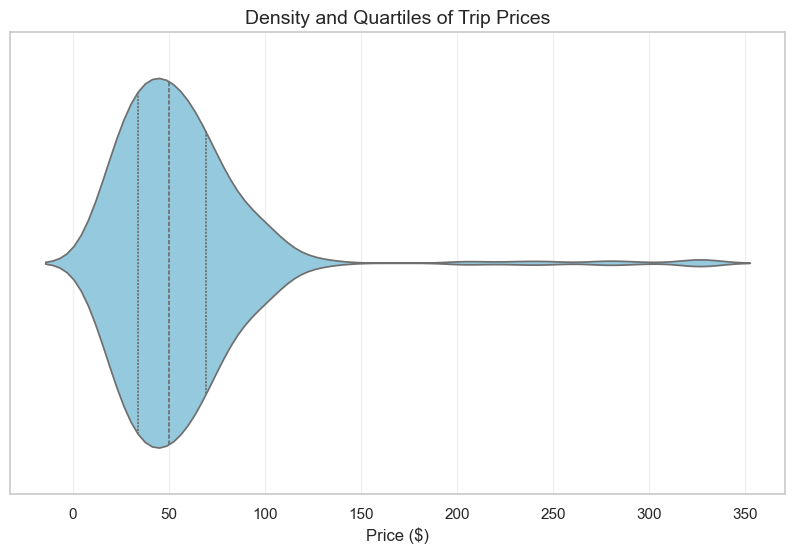

In [136]:
#Combine boxplot stats with KDE shape.
#Comparing multimodal distributions.

plt.figure(figsize=(10, 6))
sns.violinplot(
    x=df1['Trip_Price'],
    color='skyblue',
    inner='quartile'  # Show quartile lines
)
plt.title("Density and Quartiles of Trip Prices", fontsize=14)
plt.xlabel("Price ($)", fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.show()

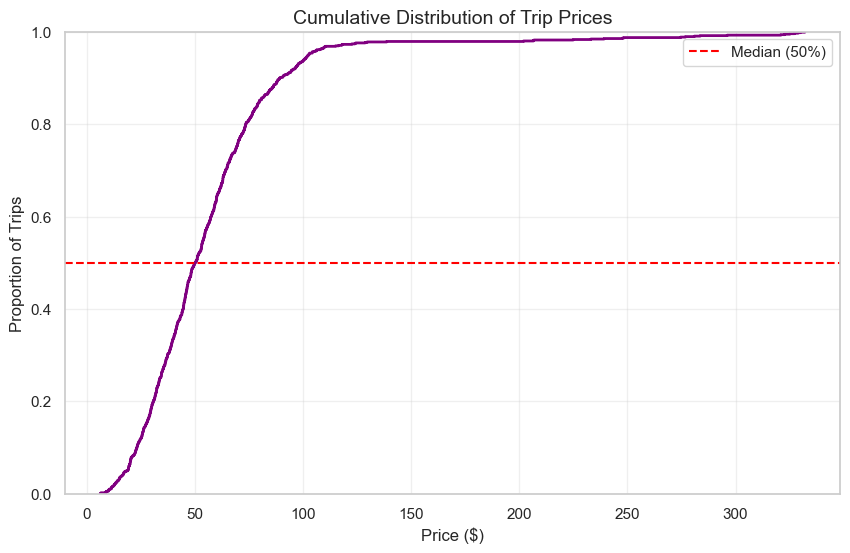

In [137]:
#"What % of trips cost less than $X?"
#Highlights percentiles (e.g., median at 50%).

plt.figure(figsize=(10, 6))
sns.ecdfplot(
    df1['Trip_Price'],
    color='purple',
    stat='proportion',  # Show % of trips below price
    linewidth=2
)
plt.title("Cumulative Distribution of Trip Prices", fontsize=14)
plt.xlabel("Price ($)", fontsize=12)
plt.ylabel("Proportion of Trips", fontsize=12)
plt.grid(alpha=0.3)
plt.axhline(0.5, color='red', linestyle='--', label='Median (50%)')
plt.legend()
plt.show()

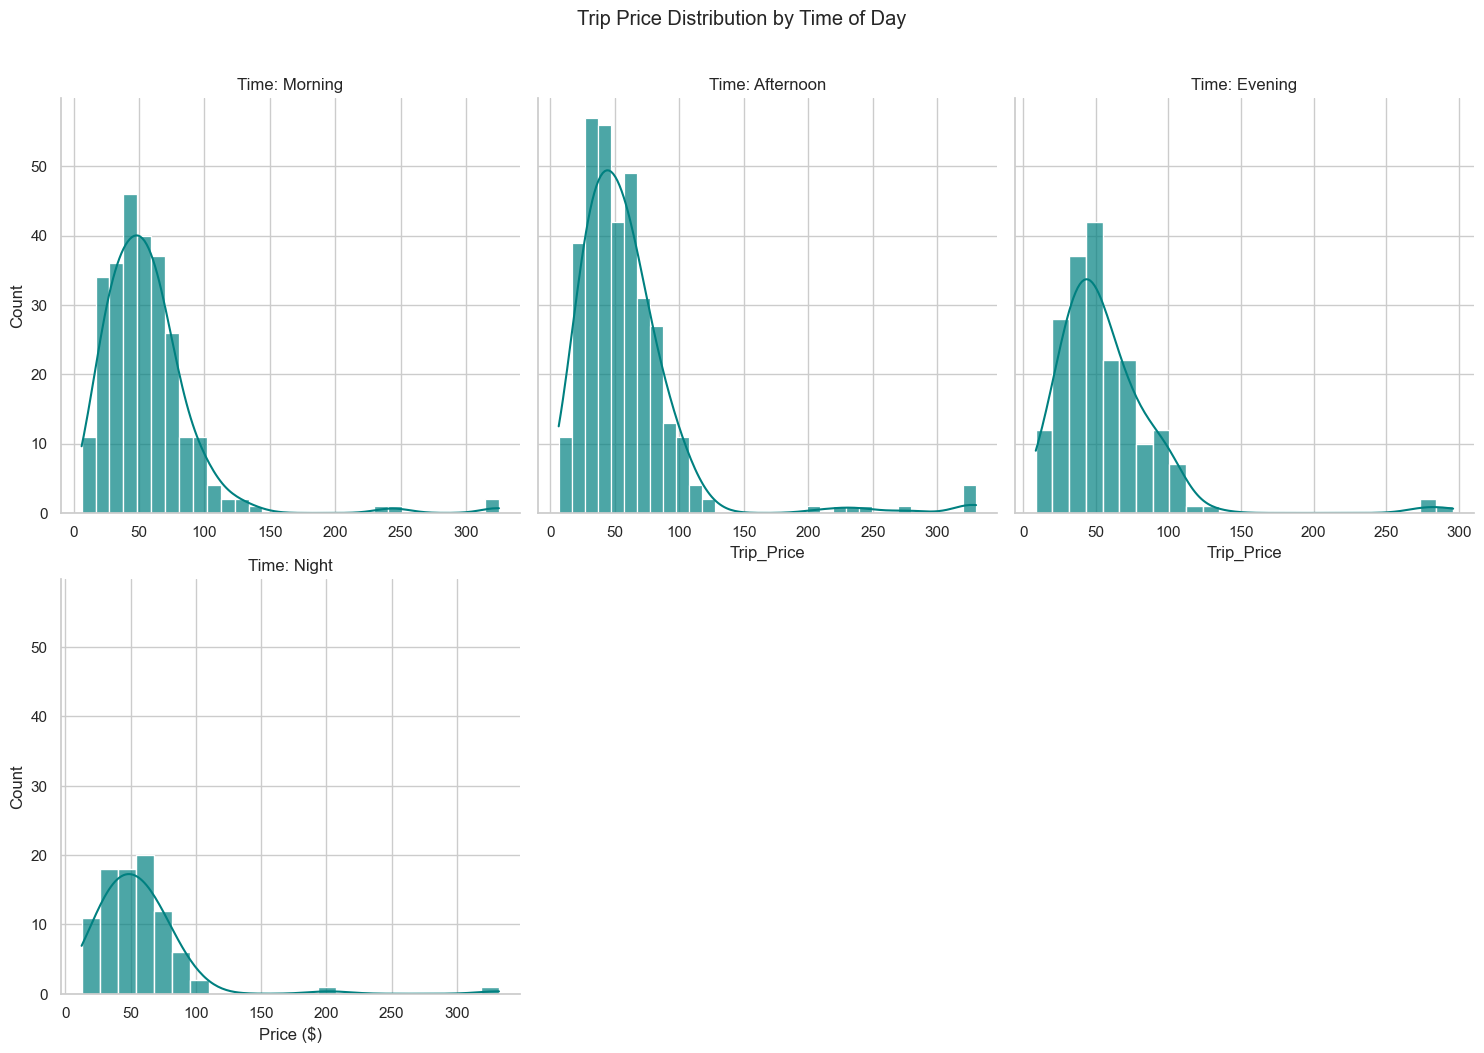

In [138]:
#Compare distributions across categories.
#Reveals if prices vary by time
g = sns.FacetGrid(
    df1,
    col='Time_of_Day',  # Split by morning/afternoon/night
    col_wrap=3,
    height=5,
    sharex=False
)
g.map(sns.histplot, 'Trip_Price', kde=True, color='teal', alpha=0.7)
g.set_titles("Time: {col_name}")
g.fig.suptitle("Trip Price Distribution by Time of Day", y=1.05)
plt.xlabel("Price ($)")
plt.show()

C:\Users\CoreTech\AppData\Local\Temp\ipykernel_14960\2564450.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




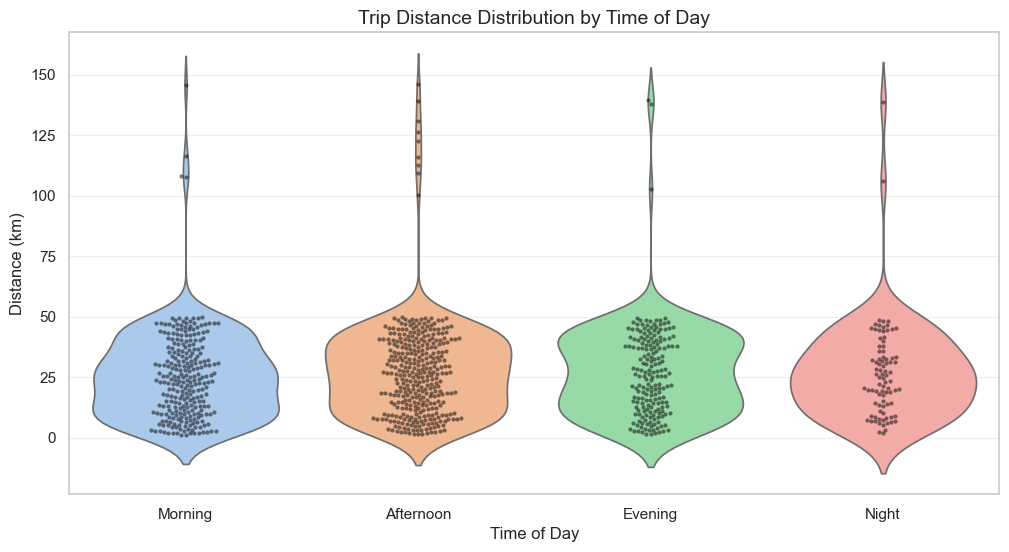

In [139]:
plt.figure(figsize=(12,6))
sns.violinplot(
    x='Time_of_Day',
    y='Trip_Distance_km',
    data=df1,
    inner=None,
    palette='pastel'
)
sns.swarmplot(
    x='Time_of_Day',
    y='Trip_Distance_km',
    data=df1,
    color='black',
    alpha=0.5,
    size=3
)
plt.title("Trip Distance Distribution by Time of Day", fontsize=14)
plt.xlabel("Time of Day", fontsize=12)
plt.ylabel("Distance (km)", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()
#Shows both distribution shape and individual trips while comparing across day periods.

C:\Users\CoreTech\AppData\Local\Temp\ipykernel_14960\2989312283.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




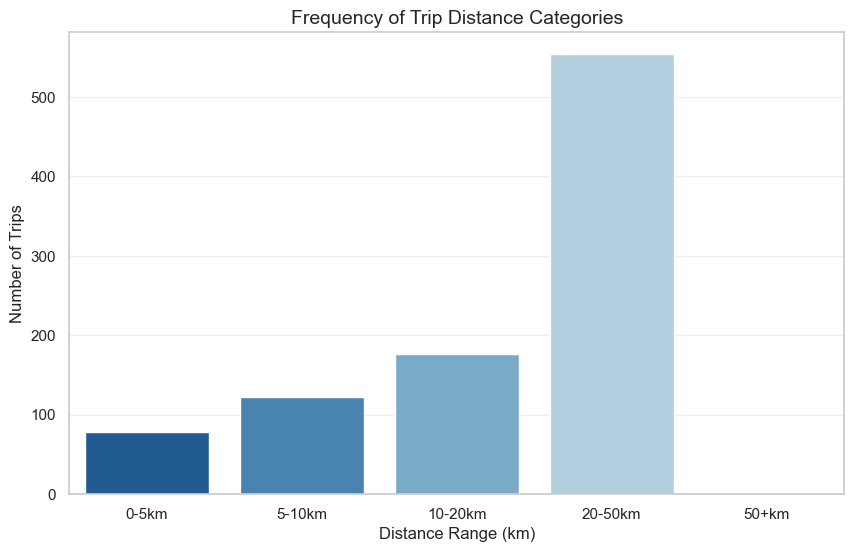

In [140]:
#Groups distances into meaningful business categories for operational analysis.
bins = [0, 5, 10, 20, 50, 100]
labels = ['0-5km', '5-10km', '10-20km', '20-50km', '50+km']
df1['Distance_Category'] = pd.cut(df1['Trip_Distance_km'], bins=bins, labels=labels)

plt.figure(figsize=(10,6))
sns.countplot(
    x='Distance_Category',
    data=df1,
    order=labels,
    palette='Blues_r'
)
plt.title("Frequency of Trip Distance Categories", fontsize=14)
plt.xlabel("Distance Range (km)", fontsize=12)
plt.ylabel("Number of Trips", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

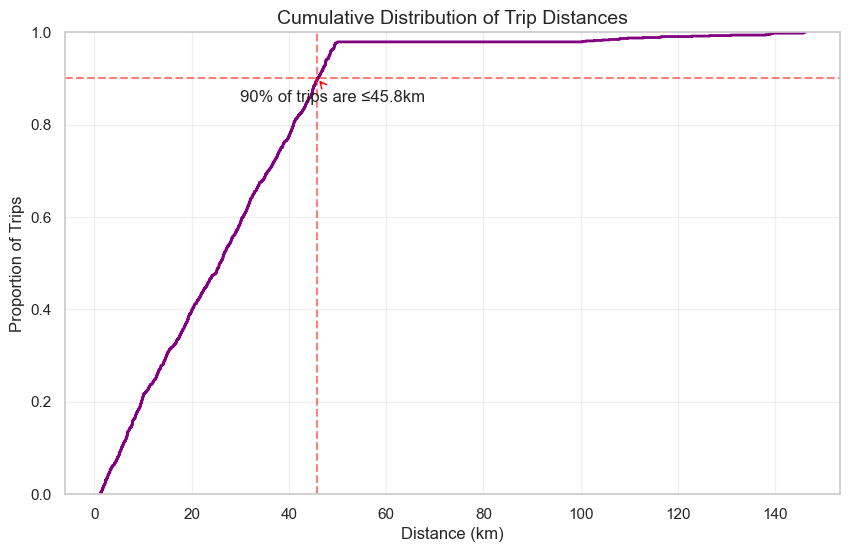

In [141]:
#"What distance covers 90% of trips?"
plt.figure(figsize=(10, 6))
sns.ecdfplot(
    data=df1,
    x='Trip_Distance_km',
    color='purple',
    linewidth=2
)

# Add reference lines and annotations
ninety_percentile = df1['Trip_Distance_km'].quantile(0.9)
plt.axhline(0.9, color='red', linestyle='--', alpha=0.5)
plt.axvline(ninety_percentile, color='red', linestyle='--', alpha=0.5)

plt.annotate(
    text='90% of trips are ≤{:.1f}km'.format(ninety_percentile),
    xy=(ninety_percentile, 0.9),
    xytext=(30, 0.85),
    arrowprops=dict(arrowstyle='->', color='red')
)

plt.title("Cumulative Distribution of Trip Distances", fontsize=14)
plt.xlabel("Distance (km)", fontsize=12)
plt.ylabel("Proportion of Trips", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

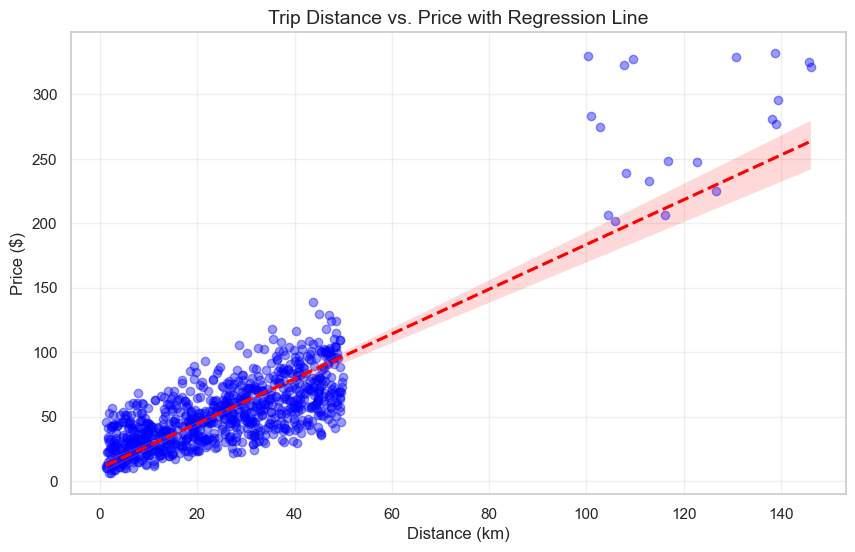

In [142]:
plt.figure(figsize=(10,6))
sns.regplot(
    x='Trip_Distance_km',
    y='Trip_Price',
    data=df1,
    scatter_kws={'alpha':0.4, 'color':'blue'},
    line_kws={'color':'red', 'linestyle':'--'}
)
plt.title("Trip Distance vs. Price with Regression Line", fontsize=14)
plt.xlabel("Distance (km)", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.grid(alpha=0.3)
plt.show()
#Reveals the pricing structure and outliers (very short expensive or long cheap trips)

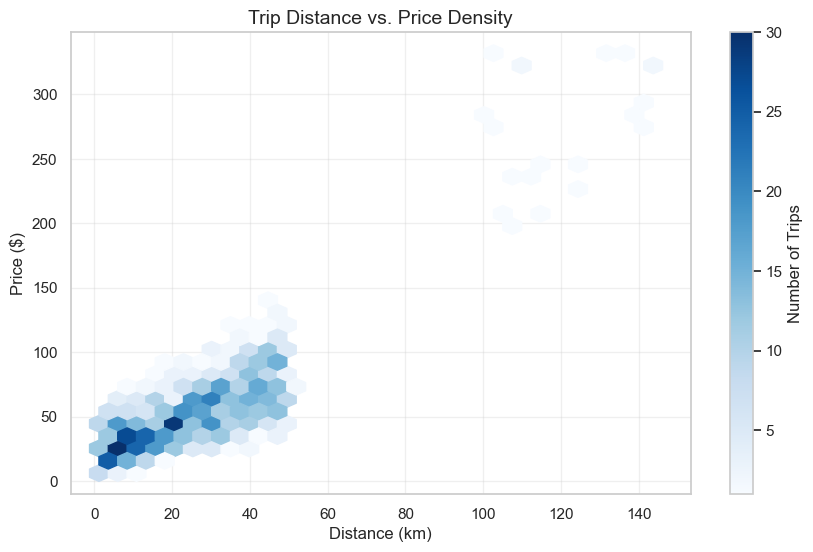

In [143]:
plt.figure(figsize=(10,6))
plt.hexbin(
    x=df1['Trip_Distance_km'],
    y=df1['Trip_Price'],
    gridsize=30,
    cmap='Blues',
    mincnt=1
)
plt.colorbar(label='Number of Trips')
plt.title("Trip Distance vs. Price Density", fontsize=14)
plt.xlabel("Distance (km)", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.grid(alpha=0.3)
plt.show()
#Better than scatter plots when you have thousands of overlapping points.

In [144]:
# Create animation
fig, ax = plt.subplots(figsize=(10, 6))
times = df1['Time_of_Day'].dropna().unique()  # Ensure no NaN values

def update(i):
    ax.clear()
    time = times[i]
    data = df1[df1['Time_of_Day'] == time]['Trip_Distance_km'].dropna()

    sns.histplot(data, kde=True, ax=ax, color='teal', bins=20)
    ax.set_title(f"Trip Distances - {time}", fontsize=14)
    ax.set_xlabel("Distance (km)", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.set_xlim(0, df1['Trip_Distance_km'].max())
    ax.grid(alpha=0.3)

ani = FuncAnimation(fig, update, frames=len(times), interval=1000)

# Display in Colab notebook
plt.close()  # Prevents double display
HTML(ani.to_jshtml())  # Renders the animation

In [145]:
#Alternative (Simpler) - Static Faceted Plot
#If animations are problematic, use this static version:

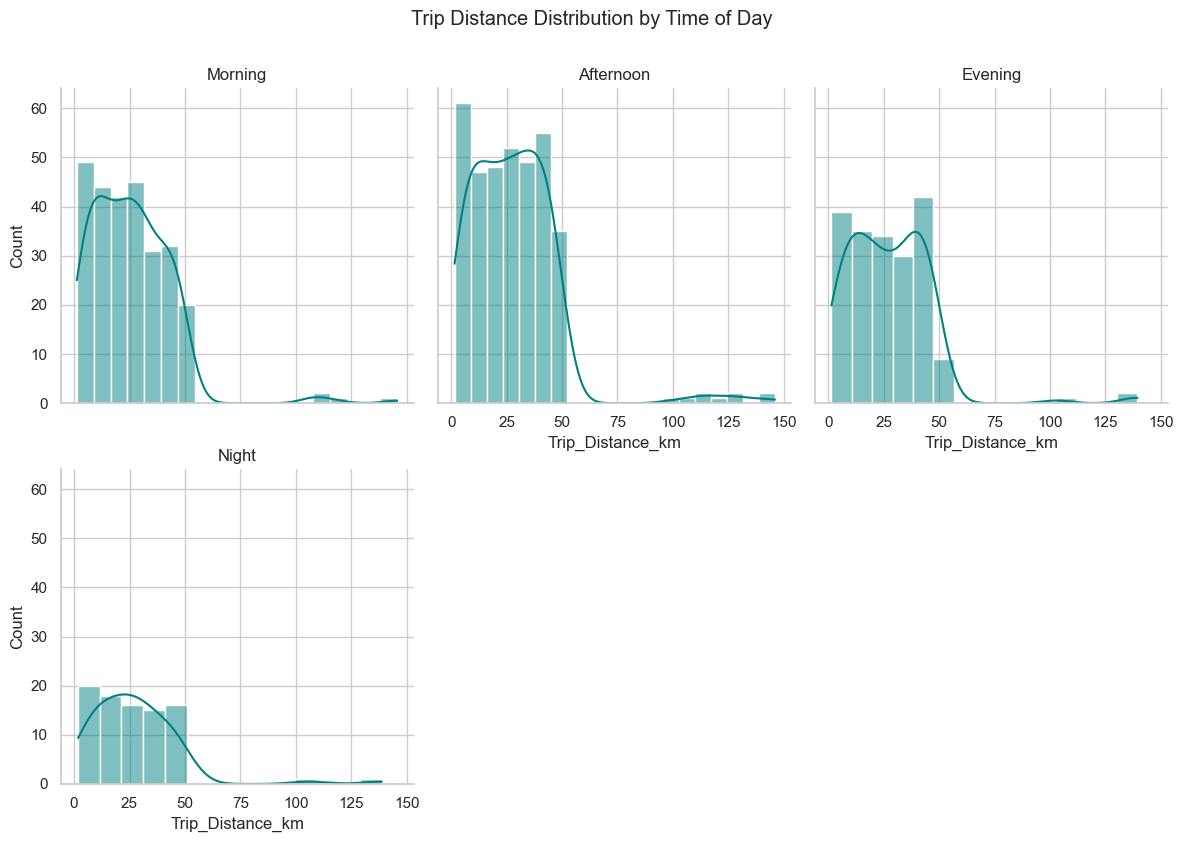

In [146]:
g = sns.FacetGrid(df1, col='Time_of_Day', col_wrap=3, height=4)
g.map(sns.histplot, 'Trip_Distance_km', kde=True, color='teal')
g.set_titles("{col_name}")
g.fig.suptitle("Trip Distance Distribution by Time of Day", y=1.05)
plt.show()

In [147]:
#checking duplicates
num_duplicates = df1.duplicated().sum()
print(f"Count of duplicates: {num_duplicates}")

Count of duplicates: 0


In [148]:
#which columns have missing values?
columns_miss = df1.columns[df1.isnull().sum() > 0]
df1[columns_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Trip_Distance_km       950 non-null    float64 
 1   Time_of_Day            950 non-null    object  
 2   Day_of_Week            950 non-null    object  
 3   Passenger_Count        950 non-null    float64 
 4   Traffic_Conditions     950 non-null    object  
 5   Weather                950 non-null    object  
 6   Base_Fare              950 non-null    float64 
 7   Per_Km_Rate            950 non-null    float64 
 8   Per_Minute_Rate        950 non-null    float64 
 9   Trip_Duration_Minutes  950 non-null    float64 
 10  Trip_Price             951 non-null    float64 
 11  Distance_Category      930 non-null    category
dtypes: category(1), float64(7), object(4)
memory usage: 87.2+ KB


In [149]:
df1.info() # bu distance category hardan geldi bura???????????

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Trip_Distance_km       950 non-null    float64 
 1   Time_of_Day            950 non-null    object  
 2   Day_of_Week            950 non-null    object  
 3   Passenger_Count        950 non-null    float64 
 4   Traffic_Conditions     950 non-null    object  
 5   Weather                950 non-null    object  
 6   Base_Fare              950 non-null    float64 
 7   Per_Km_Rate            950 non-null    float64 
 8   Per_Minute_Rate        950 non-null    float64 
 9   Trip_Duration_Minutes  950 non-null    float64 
 10  Trip_Price             951 non-null    float64 
 11  Distance_Category      930 non-null    category
dtypes: category(1), float64(7), object(4)
memory usage: 87.2+ KB


In [150]:
df1.describe()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
count,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,951.000000
mean,27.070547,2.476842,3.502989,1.233316,0.292916,62.118116,56.874773
std,19.905300,1.102249,0.870162,0.429816,0.115592,32.154406,40.469791
min,1.230000,1.000000,2.010000,0.500000,0.100000,5.010000,6.126900
25%,12.632500,1.250000,2.730000,0.860000,0.190000,35.882500,33.742650
50%,25.830000,2.000000,3.520000,1.220000,0.290000,61.860000,50.074500
75%,38.405000,3.000000,4.260000,1.610000,0.390000,89.055000,69.099350
max,146.067047,4.000000,5.000000,2.000000,0.500000,119.840000,332.043689


In [151]:
df1.isnull().sum()

Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Conditions       50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
Distance_Category        70
dtype: int64

In [152]:
print(df1["Distance_Category"].unique())


['10-20km', '20-50km', NaN, '5-10km', '0-5km']
Categories (5, object): ['0-5km' < '5-10km' < '10-20km' < '20-50km' < '50+km']


In [153]:
df1 = df1.drop("Distance_Category", axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB



📊 **Trip_Distance_km**
   Mean: 27.07 | Median: 25.83 | Skewness: 2.24
   Missing Values: 50 (5.0%)


<Figure size 1000x600 with 0 Axes>

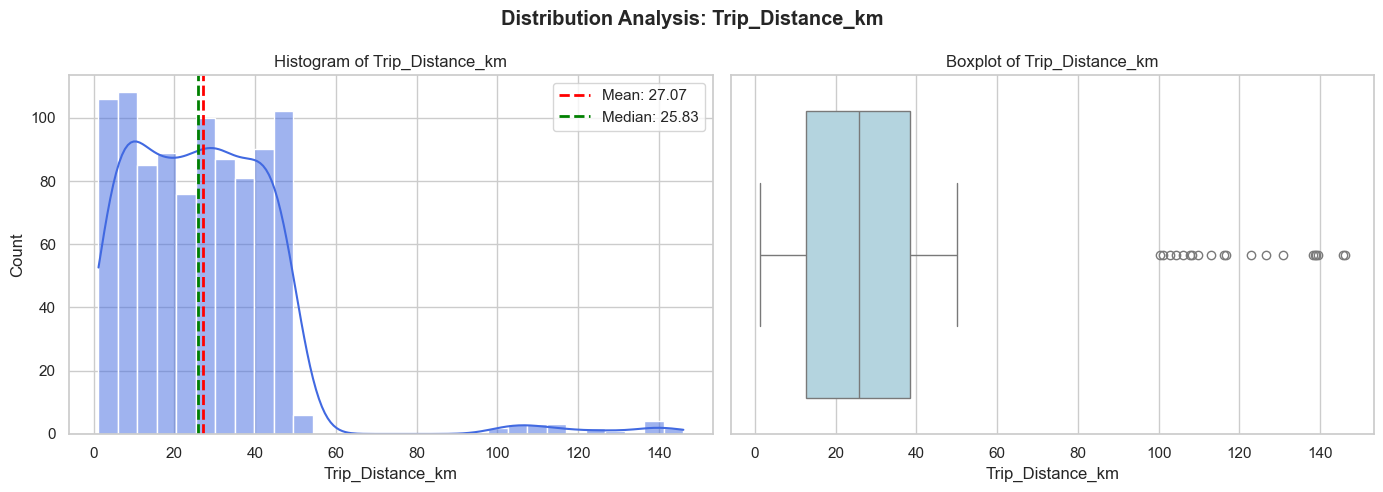


📊 **Passenger_Count**
   Mean: 2.48 | Median: 2.00 | Skewness: 0.02
   Missing Values: 50 (5.0%)


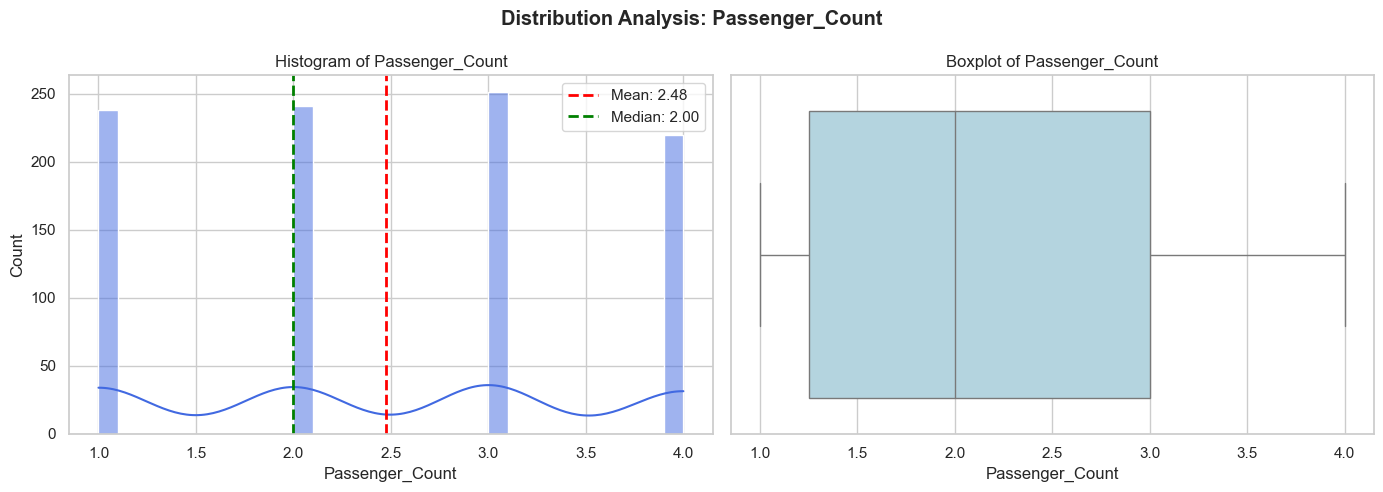


📊 **Base_Fare**
   Mean: 3.50 | Median: 3.52 | Skewness: -0.01
   Missing Values: 50 (5.0%)


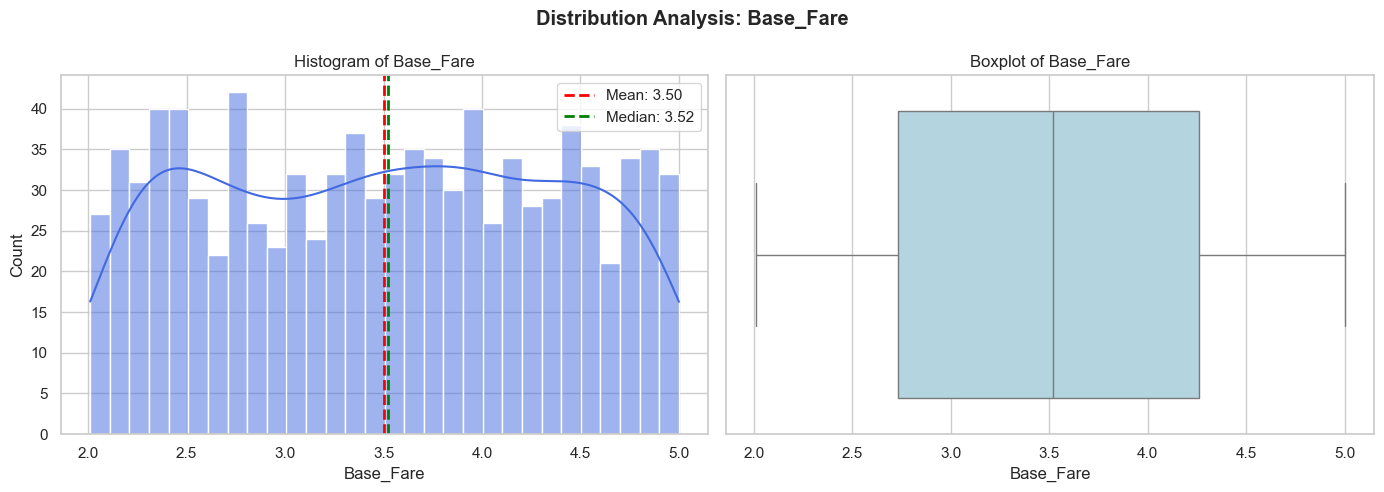


📊 **Per_Km_Rate**
   Mean: 1.23 | Median: 1.22 | Skewness: 0.08
   Missing Values: 50 (5.0%)


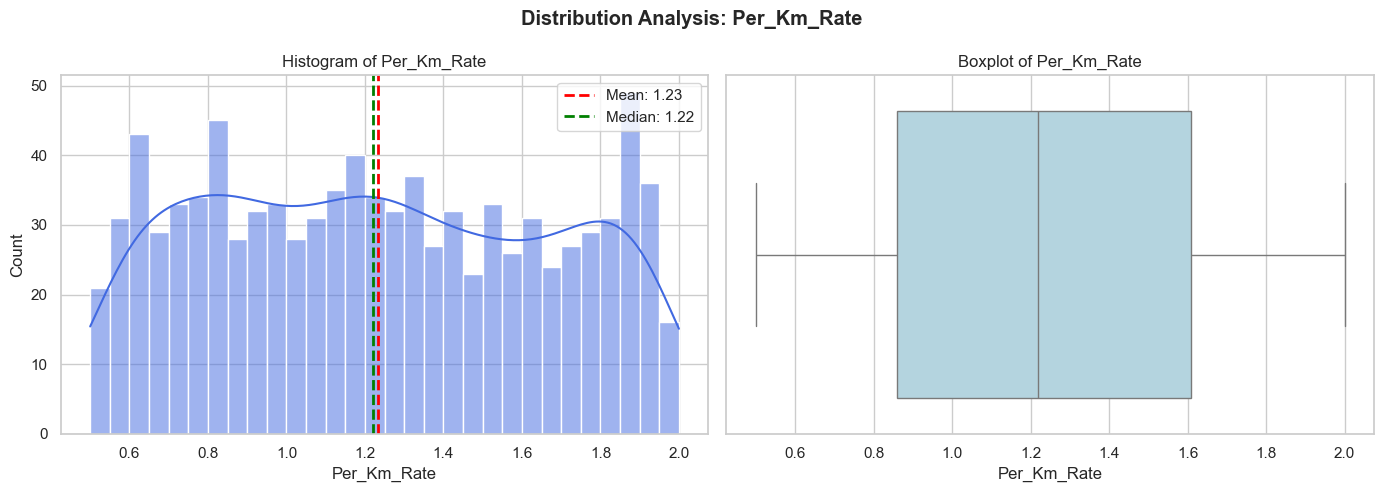


📊 **Per_Minute_Rate**
   Mean: 0.29 | Median: 0.29 | Skewness: 0.06
   Missing Values: 50 (5.0%)


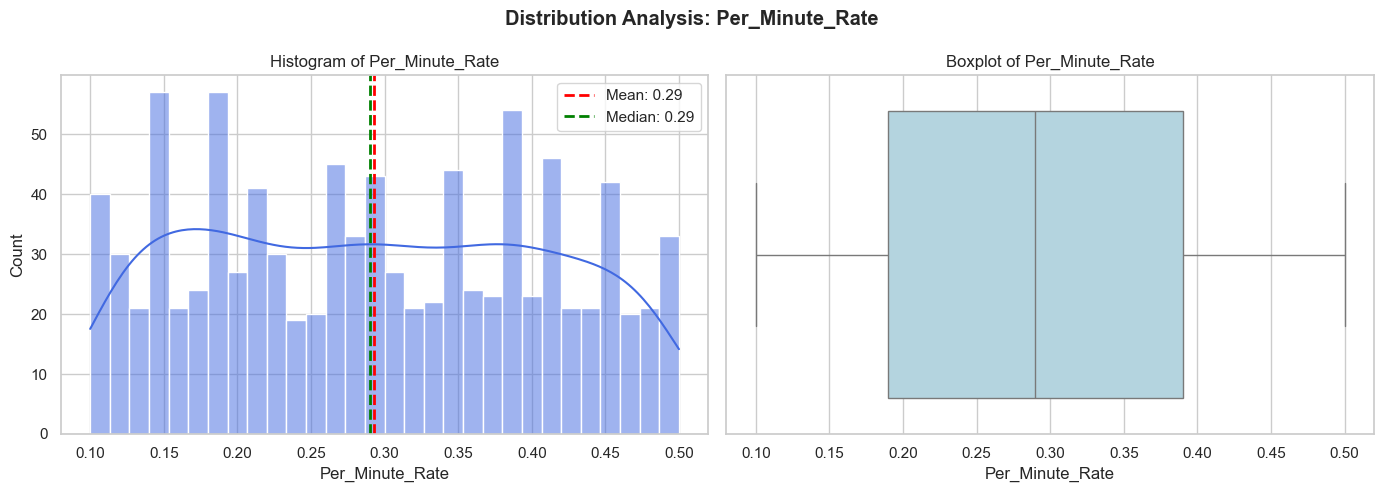


📊 **Trip_Duration_Minutes**
   Mean: 62.12 | Median: 61.86 | Skewness: 0.02
   Missing Values: 50 (5.0%)


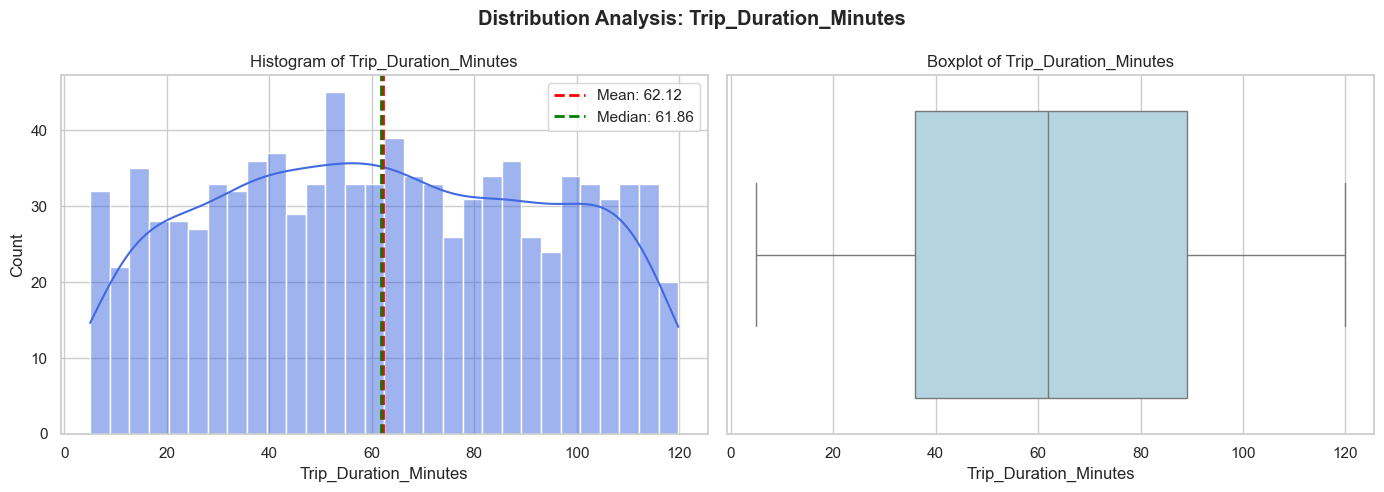


📊 **Trip_Price**
   Mean: 56.87 | Median: 50.07 | Skewness: 3.73
   Missing Values: 49 (4.9%)


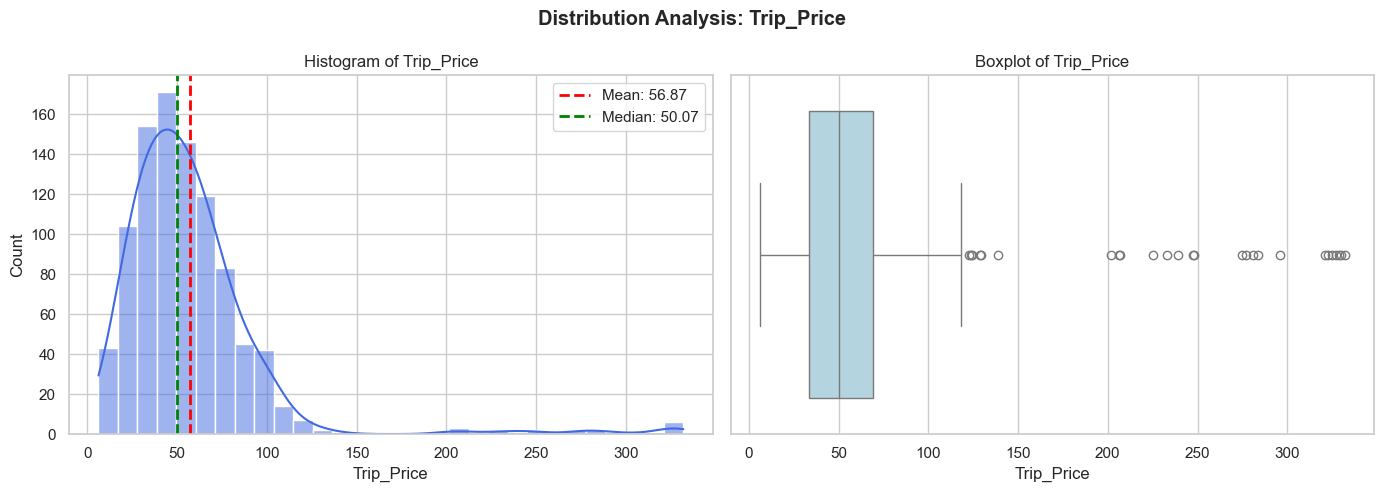

In [154]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

columns_with_missing = [
    'Trip_Distance_km',
    'Passenger_Count',
    'Base_Fare',
    'Per_Km_Rate',
    'Per_Minute_Rate',
    'Trip_Duration_Minutes',
    'Trip_Price'
]

for col in columns_with_missing:
    # Calculate stats
    mean_val = df1[col].mean()
    median_val = df1[col].median()
    skewness = df1[col].skew()

    # Print formatted stats
    print(f"\n📊 **{col}**")
    print(f"   Mean: {mean_val:.2f} | Median: {median_val:.2f} | Skewness: {skewness:.2f}")
    print(f"   Missing Values: {df1[col].isnull().sum()} ({(df1[col].isnull().mean() * 100):.1f}%)")

    # Create subplots for better comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"Distribution Analysis: {col}", fontweight='bold')

    # Histogram with KDE
    sns.histplot(df1[col], bins=30, kde=True, ax=ax1, color='royalblue')
    ax1.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax1.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    ax1.legend()
    ax1.set_title(f"Histogram of {col}")

    # Boxplot to detect outliers
    sns.boxplot(x=df1[col], ax=ax2, color='lightblue')
    ax2.set_title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()

In [155]:
columns_to_fill = [
    'Trip_Distance_km',
    'Passenger_Count',
    'Base_Fare',
    'Per_Km_Rate',
    'Per_Minute_Rate',
    'Trip_Duration_Minutes',
    'Trip_Price'
]

for column in columns_to_fill:
    median_val = df1[column].median()
    df1[column].fillna(median_val, inplace=True)

C:\Users\CoreTech\AppData\Local\Temp\ipykernel_14960\2136097013.py:13: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [156]:
df1.isnull().sum()  # numerical must have 0

Trip_Distance_km          0
Time_of_Day              50
Day_of_Week              50
Passenger_Count           0
Traffic_Conditions       50
Weather                  50
Base_Fare                 0
Per_Km_Rate               0
Per_Minute_Rate           0
Trip_Duration_Minutes     0
Trip_Price                0
dtype: int64

In [157]:
categorical_cols = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']
for col in categorical_cols:
    mode_val = df1[col].mode()[0]  # Get the first mode
    df1[col].fillna(mode_val, inplace=True)

C:\Users\CoreTech\AppData\Local\Temp\ipykernel_14960\3561382558.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [158]:
df1.isnull().sum()  # all must have 0

Trip_Distance_km         0
Time_of_Day              0
Day_of_Week              0
Passenger_Count          0
Traffic_Conditions       0
Weather                  0
Base_Fare                0
Per_Km_Rate              0
Per_Minute_Rate          0
Trip_Duration_Minutes    0
Trip_Price               0
dtype: int64

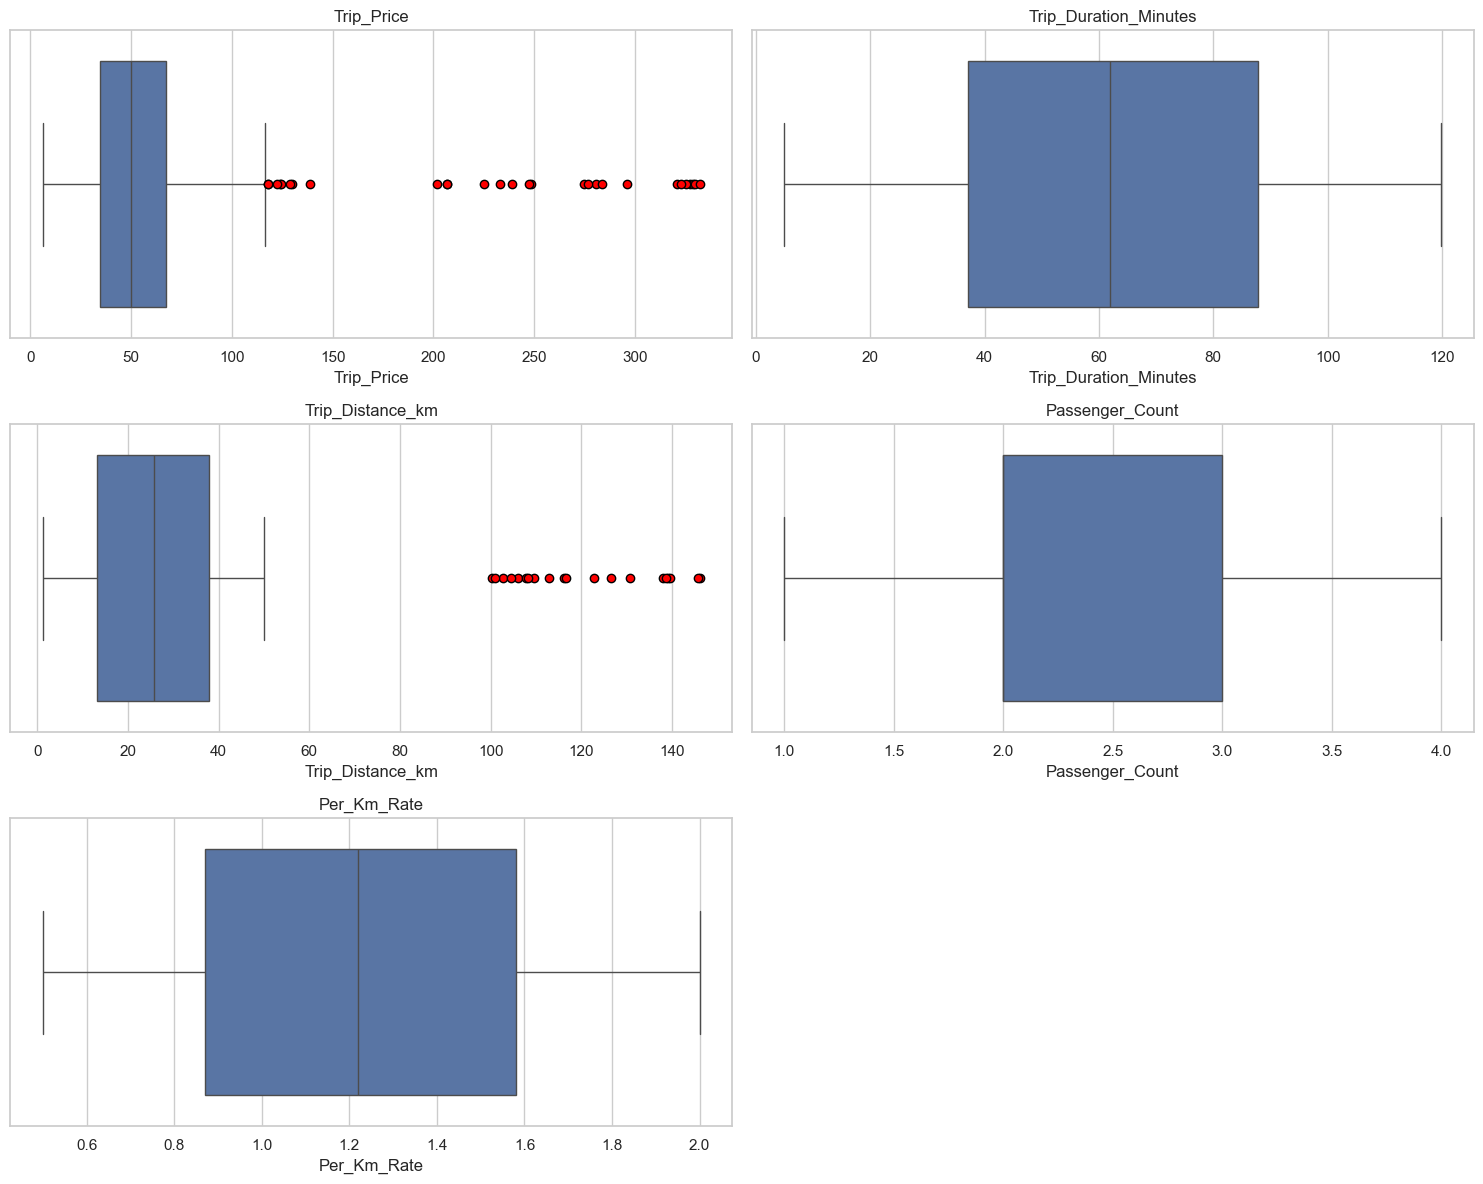

In [159]:
# Set up the figure and subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Custom outlier styling (red circles)
outlier_props = dict(marker='o', markerfacecolor='red', markersize=6, markeredgecolor='black')

# Plot each boxplot with red outliers
sns.boxplot(x=df1['Trip_Price'], ax=axes[0, 0], flierprops=outlier_props)
axes[0, 0].set_title('Trip_Price')

sns.boxplot(x=df1['Trip_Duration_Minutes'], ax=axes[0, 1], flierprops=outlier_props)
axes[0, 1].set_title('Trip_Duration_Minutes')

sns.boxplot(x=df1['Trip_Distance_km'], ax=axes[1, 0], flierprops=outlier_props)
axes[1, 0].set_title('Trip_Distance_km')

sns.boxplot(x=df1['Passenger_Count'], ax=axes[1, 1], flierprops=outlier_props)
axes[1, 1].set_title('Passenger_Count')

sns.boxplot(x=df1['Per_Km_Rate'], ax=axes[2, 0], flierprops=outlier_props)
axes[2, 0].set_title('Per_Km_Rate')

# Remove the empty subplot
fig.delaxes(axes[2, 1])

# Adjust layout and display
plt.tight_layout()
plt.show()

                       Trip_Distance_km  Passenger_Count  Base_Fare  \
Trip_Distance_km               1.000000        -0.028060   0.043345   
Passenger_Count               -0.028060         1.000000   0.021889   
Base_Fare                      0.043345         0.021889   1.000000   
Per_Km_Rate                   -0.035999         0.024647  -0.001481   
Per_Minute_Rate               -0.019611         0.026669  -0.016841   
Trip_Duration_Minutes         -0.033462         0.022904   0.013380   
Trip_Price                     0.683403         0.021726   0.044288   

                       Per_Km_Rate  Per_Minute_Rate  Trip_Duration_Minutes  \
Trip_Distance_km         -0.035999        -0.019611              -0.033462   
Passenger_Count           0.024647         0.026669               0.022904   
Base_Fare                -0.001481        -0.016841               0.013380   
Per_Km_Rate               1.000000         0.028306               0.025799   
Per_Minute_Rate           0.028306       

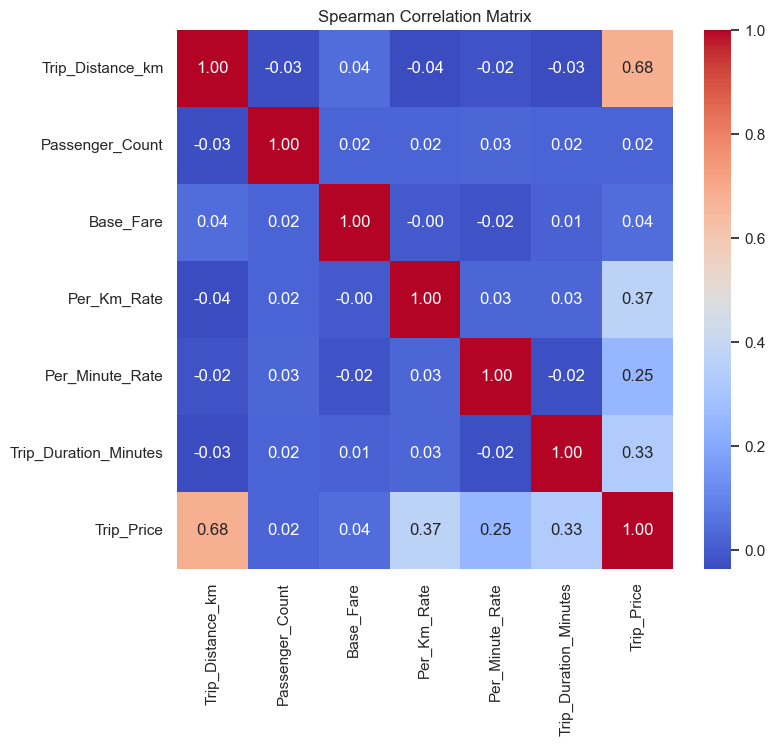

In [160]:
numeric_df = df1.select_dtypes(include=['number'])
spearman_corr = numeric_df.corr(method='spearman')

print(spearman_corr)

plt.figure(figsize=(8, 7))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Spearman Correlation Matrix')
plt.show()

In [161]:
df1['Time_of_Day'].unique()

array(['Morning', 'Afternoon', 'Evening', 'Night'], dtype=object)

In [162]:
df = pd.get_dummies(df1, columns=['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather'])
X = df.drop(['Trip_Price'], axis = 1)
y = df['Trip_Price']

feature_names = X.columns

numeric_columns = ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']

scaler = RobustScaler()

X_scaled = X.copy()
X_scaled[numeric_columns] = scaler.fit_transform(X[numeric_columns])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.40, random_state=100)

In [163]:
df.head

<bound method NDFrame.head of      Trip_Distance_km  Passenger_Count  Base_Fare  Per_Km_Rate  \
0               19.35              3.0       3.56         0.80   
1               47.59              1.0       3.52         0.62   
2               36.87              1.0       2.70         1.21   
3               30.33              4.0       3.48         0.51   
4               25.83              3.0       2.93         0.63   
..                ...              ...        ...          ...   
995              5.49              4.0       2.39         0.62   
996             45.95              4.0       3.12         0.61   
997              7.70              3.0       2.08         1.78   
998             47.56              1.0       2.67         0.82   
999             22.85              3.0       4.34         1.22   

     Per_Minute_Rate  Trip_Duration_Minutes  Trip_Price  \
0               0.32                  53.82     36.2624   
1               0.43                  40.57     50.0745   


In [164]:
print(X_train)

     Trip_Distance_km  Passenger_Count  Base_Fare  Per_Km_Rate  \
761         -0.387437             -1.0   0.719023    -0.605634   
328         -0.173050             -1.0   0.000000     0.408451   
943          0.000000             -1.0  -0.991274     0.352113   
552          0.089564              2.0   0.062827     0.943662   
994         -0.289362              1.0   0.963351     0.802817   
..                ...              ...        ...          ...   
855         -0.627761             -1.0   0.970332     0.591549   
871         -0.468490             -1.0   0.000000     0.323944   
835          4.081768             -1.0   0.495637    -0.521127   
792         -0.001621              0.0   0.935428    -0.788732   
520          0.173455              1.0  -0.188482     0.154930   

     Per_Minute_Rate  Trip_Duration_Minutes  Time_of_Day_Afternoon  \
761        -0.648649               0.000000                  False   
328         0.162162              -0.233680                   True 

In [165]:
#XGBoost
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae')

param_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5, 10],
    'subsample': [0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

grid_search__xgb = GridSearchCV(xgb_regressor, param_xgb, cv=5)

grid_search__xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric='mae',
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 5, 10],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]})

In [166]:
grid_search__xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 100,
 'subsample': 0.8}

In [167]:
best_gs_xgb_two = grid_search__xgb.best_estimator_

In [168]:
print('Score on train data = ', round(best_gs_xgb_two.score(X_train, y_train), 4))
print('Score on test data = ', round(best_gs_xgb_two.score(X_test, y_test), 4))

Score on train data =  0.9686
Score on test data =  0.8339


In [169]:
y_test_pred4 = best_gs_xgb_two.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred4)
print('MAE on test data =', round(mae_test, 4))

MAE on test data = 6.4888


In [170]:
#

In [171]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [172]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
# Import LinearRegression if it's not already imported in this cell
from sklearn.linear_model import LinearRegression


models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf', C=100, epsilon=0.1)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    # Change y_train_log to y_train
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Change y_test_log to y_test
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name} -> RMSE: {rmse:.4f}, R2: {r2:.4f}\n")

# Optional: print summary
print("Summary of model performance on log-transformed target:")
for name, metrics in results.items():
    print(f"{name}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}")

Training Linear Regression...
Linear Regression -> RMSE: 13.8606, R2: 0.7687

Training Ridge Regression...
Ridge Regression -> RMSE: 13.9412, R2: 0.7660

Training Random Forest...
Random Forest -> RMSE: 7.6359, R2: 0.9298

Training Gradient Boosting...
Gradient Boosting -> RMSE: 7.2951, R2: 0.9359

Training Support Vector Regression...
Support Vector Regression -> RMSE: 14.7083, R2: 0.7396

Summary of model performance on log-transformed target:
Linear Regression: RMSE = 13.8606, R2 = 0.7687
Ridge Regression: RMSE = 13.9412, R2 = 0.7660
Random Forest: RMSE = 7.6359, R2 = 0.9298
Gradient Boosting: RMSE = 7.2951, R2 = 0.9359
Support Vector Regression: RMSE = 14.7083, R2 = 0.7396


In [173]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
print("Re-training Random Forest for saving...")
rf_model.fit(X_train, y_train)
print("Random Forest re-trained.")

Re-training Random Forest for saving...
Random Forest re-trained.


In [174]:
import joblib

joblib.dump(rf_model, 'random_forest_taxi_model.pkl')

['random_forest_taxi_model.pkl']

In [175]:
model = joblib.load('random_forest_taxi_model.pkl')